# 流程

以图片搜索为例，展示如何使用 Tablestore 的向量检索能力进行多模态检索。

1. 准备演示数据
    1. 准备一批样式丰富的图片
    2. 使用百炼模型，将图片转换为向量
2. 创建实例
3. 创建表和索引
4. 写入数据
5. 查询数据
6. 可视化演示

# 数据演示准备

image count:968


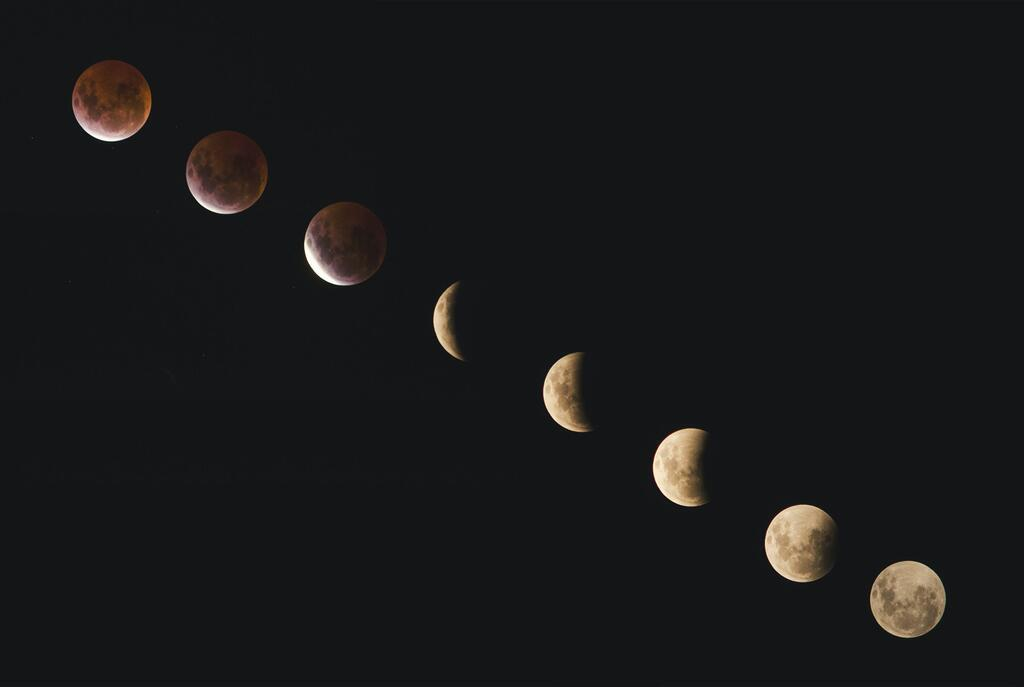

In [1]:
import os

from PIL import Image

base_path = "../data/photograph/"
all_image_files = os.listdir(base_path)
print(f"image count:{len(all_image_files)}")

for image_name in all_image_files[1:2]:
    img = Image.open(base_path + image_name)
    display(img)

### Embedding

这里以某一张图片进行示例，后续会批量进行 Embedding. 
更多的多模态模型请参考百炼的 [官网文档-多模态向量](https://help.aliyun.com/zh/model-studio/models#9bda215aa7mko)

#### 1. 通过图片URL Embedding 图片 
当图片已经在OSS的场景下，可以直接使用这种方式来 Embedding 生成向量。

In [15]:
from dashscope import MultiModalEmbeddingItemImage
import dashscope

image_url = "http://oss-vector-resources.oss-cn-hangzhou.aliyuncs.com/photograph/Zsd0YhBa8LM.jpg"
resp = dashscope.MultiModalEmbedding.call(
    model="multimodal-embedding-v1",
    input=[MultiModalEmbeddingItemImage(image=image_url, factor=1.0)]
)
embedding = resp.output["embeddings"][0]["embedding"]
# 打印前10维度
print(embedding[0:10])

[0.0485953763127327, 0.05155894532799721, -0.033152688294649124, -0.021387679502367973, 0.0499521903693676, 0.04627450928092003, 0.011979242786765099, -0.014710724353790283, 0.040383078157901764, -0.012862957082688808]


##### 2. 本地图片直接 Embedding

In [20]:
import base64
from dashscope import MultiModalEmbeddingItemImage

from PIL import Image
import io

image_file_to_embedding = "../data/photograph/Zsd0YhBa8LM.jpg"


def get_image_embedding(image_path):
    # 打开需要Embedding的图片
    with Image.open(image_path) as img:
        buffered = io.BytesIO()
        img_format = img.format.lower()
        print(f"image_path:[{image_path}], img_format:[{img_format}]")
        img.save(buffered, img_format)
        base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')

        # 构造 data URI
        data_uri = f"data:{img_format};base64,{base64_image}"
        embedding_resp = dashscope.MultiModalEmbedding.call(
            model="multimodal-embedding-v1",
            input=[MultiModalEmbeddingItemImage(image=data_uri, factor=1.0)]
        )
        if embedding_resp.status_code == 200:
            return embedding_resp.output["embeddings"][0]["embedding"]
        else:
            raise Exception(f"向量化失败: {embedding_resp.code} - {embedding_resp.message}")


embedding = get_image_embedding(image_file_to_embedding)
# 打印前10维度
print(embedding[0:10])

image_path:[../data/photograph/Zsd0YhBa8LM.jpg], img_format:[jpeg]
[0.048595186322927475, 0.05155874416232109, -0.03317040950059891, -0.02136974222958088, 0.04995199665427208, 0.04631003364920616, 0.012014901265501976, -0.014719593338668346, 0.04038292169570923, -0.01286290679126978]


##### 3. Embedding 文本
下面展示多模态的文本能力。 因模型支持文本、图片、视频等，只要把数据写入到 Tablestore 中，查询时候可以做到图搜图、文搜图能力。

In [ ]:
from dashscope import MultiModalEmbeddingItemText
import dashscope

resp = dashscope.MultiModalEmbedding.call(
    model="multimodal-embedding-v1",
    input=[MultiModalEmbeddingItemText(text="风景优美的西湖", factor=1.0)]
)
print(resp)

# 初始化 Client 

In [ ]:
import os
import tablestore

endpoint = os.getenv("tablestore_end_point")
instance_name = os.getenv("tablestore_instance_name")
access_key_id = os.getenv("tablestore_access_key_id")
access_key_secret = os.getenv("tablestore_access_key_secret")

# 创建 tablestore 的 sdk client
client = tablestore.OTSClient(
    endpoint,
    access_key_id,
    access_key_secret,
    instance_name,
    retry_policy=tablestore.WriteRetryPolicy(),
)

table_name = "multi_modal_retrieval"
index_name = "index"
dimension = 1024

# 创建实例

控制台操作即可。


# 创建表和索引

### 创建表

In [ ]:
try:
    # 主键
    schema_of_primary_key = [("image_id", "STRING")]
    table_meta = tablestore.TableMeta(table_name, schema_of_primary_key)
    table_options = tablestore.TableOptions()
    reserved_throughput = tablestore.ReservedThroughput(tablestore.CapacityUnit(0, 0))
    client.create_table(table_meta, table_options, reserved_throughput)
except Exception as e:
    print(e)

### 创建索引

In [ ]:
metadata_mappings = [
    tablestore.FieldSchema(
        "image_id",
        tablestore.FieldType.KEYWORD,
        index=True,
        enable_sort_and_agg=True,
    ),
    tablestore.FieldSchema(
        "city",
        tablestore.FieldType.KEYWORD,
        index=True,
        enable_sort_and_agg=True,

    ),
    tablestore.FieldSchema(
        "height",
        tablestore.FieldType.LONG,
        index=True,
        enable_sort_and_agg=True,

    ),
    tablestore.FieldSchema(
        "width",
        tablestore.FieldType.LONG,
        index=True,
        enable_sort_and_agg=True,

    ),
    tablestore.FieldSchema(
        "vector",
        tablestore.FieldType.VECTOR,
        vector_options=tablestore.VectorOptions(
            data_type=tablestore.VectorDataType.VD_FLOAT_32,
            dimension=dimension,
            metric_type=tablestore.VectorMetricType.VM_COSINE,
        ),
    ),
]
try:
    index_meta = tablestore.SearchIndexMeta(metadata_mappings)
    client.create_search_index(table_name, index_name, index_meta)
except Exception as e:
    print(e)

# 写入数据

### 准备图片数据

因 Embedding 模型调用较慢，我们提前调用 Embedding 模型准备好了数据。其它类似数据可以参考最上面的“Embedding”章节来生成。

In [ ]:
import json

image_data_array = []
with open("../data/data.json", "r") as f:
    image_data_array = json.load(f)
print("image data count:", len(image_data_array))

### 写入图片数据

In [ ]:
batch_size = 100
put_row_items = []
for idx in range(len(image_data_array)):
    image_data = image_data_array[idx]
    primary_key = [("image_id", image_data["image_id"])]
    attribute_columns = [
        ("city", image_data["city"]),
        ("vector", json.dumps(image_data["vector"])),
        ("width", image_data["width"]),
        ("height", image_data["height"]),
    ]
    row = tablestore.Row(primary_key, attribute_columns)
    condition = tablestore.Condition(tablestore.RowExistenceExpectation.IGNORE)
    item = tablestore.PutRowItem(row, condition)
    put_row_items.append(item)
    if len(put_row_items) == batch_size or (len(put_row_items) > 0 and idx == len(image_data_array) - 1):
        request = tablestore.BatchWriteRowRequest()
        request.add(tablestore.TableInBatchWriteRowItem(table_name, put_row_items))
        result: tablestore.metadata.BatchWriteRowResponse = client.batch_write_row(request)
        print(f'batch write {len(put_row_items)} rows is_all_succeed: {result.is_all_succeed()}')
        put_row_items = []

### 查询一行数据

In [ ]:
try:
    primary_key = [('image_id', "0")]
    _, return_row, _ = client.get_row(table_name, primary_key)
    # 主键
    print(f"pk:{return_row.primary_key}")
    # 属性列
    for att in return_row.attribute_columns:
        # 打印每一列的key、value和version值。
        print(f'column_name:{att[0]} column_value:{att[1]}')
except Exception as e:
    print(e)


### 删除一行数据

In [ ]:
try:
    primary_key = [('image_id', "0")]
    row = tablestore.Row(primary_key)
    client.delete_row(table_name, row)
except Exception as e:
    print(e)


### 多模态检索

以下展示文搜图(文本生成向量进行查询)，想实现“图搜图”只需要将图片生成向量传入Query中即可。

In [ ]:
import dashscope
from dashscope import MultiModalEmbeddingItemText


def embedding(text) -> list[float]:
    return dashscope.MultiModalEmbedding.call(
        model="multimodal-embedding-v1",
        input=[MultiModalEmbeddingItemText(text=text, factor=1.0)]
    ).output["embeddings"][0]["embedding"]

In [ ]:
try:
    top_k = 20
    query = tablestore.KnnVectorQuery(
        field_name='vector',
        top_k=top_k,
        float32_query_vector=embedding("狗狗"),
        filter=tablestore.BoolQuery(
            must_queries=[
                tablestore.TermQuery(field_name='city', column_value="hangzhou"),
                tablestore.RangeQuery(
                    field_name='height',
                    range_from=0,
                    range_to=1024,
                    include_lower=True,
                    include_upper=True
                ),
            ]
        )
    )
    # 按照分数排序。
    sort = tablestore.Sort(sorters=[tablestore.ScoreSort(sort_order=tablestore.SortOrder.DESC)])
    search_query = tablestore.SearchQuery(
        query,
        limit=top_k,
        get_total_count=False,
        sort=sort
    )
    search_response: tablestore.SearchResponse = client.search(
        table_name=table_name,
        index_name=index_name,
        search_query=search_query,
        columns_to_get=tablestore.ColumnsToGet(
            column_names=["image_id", "city", "height", "width"],
            return_type=tablestore.ColumnReturnType.SPECIFIED)
    )
    print(f"search request_id:{search_response.request_id}")
    search_hits: list[tablestore.metadata.SearchHit] = search_response.search_hits
    for hit in search_hits:
        row_item = {}
        primary_key = hit.row[0]
        row_item["image_id"] = primary_key[0][1]
        attribute_columns = hit.row[1]
        for col in attribute_columns:
            key = col[0]
            val = col[1]
            row_item[key] = val
        print(f"score:{hit.score}, row:{row_item}")
except Exception as e:
    print(e)


# 图形化展示

为了更好的展示效果，使用 Gradio 做了一个界面进行演示。